## Forecasting Out-of-Sample

1. import packages and specific functions from the ``serf`` package.

In [1]:
import numpy as np
import geopandas as gp
import pandas as pd
import datetime as dt

from statsmodels.tsa.statespace.sarimax import SARIMAX

# import .py scripts from repo 
from json_to_csv import geojson_to_csv
from ts_train_test_split import uni_selection
from forecast_single import forecast

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

### import csv with geolocation metadata 

Use ``pd.read_csv`` to access the metadata and hyperparameters needed for the forecasting model. In this case, ``Final_validation.csv`` contains the optimized hyperparameters for SARIMAX, the filepath name for the geojsons, and results of the validation tests with the optimized hyperparameters.

In [2]:
locations = pd.read_csv('Final_validation.csv', index_col=0)
locations

,lat,lon,Place,p,d,q,P,D,Q,filepath,MSE,r2
0,49.0362,-122.3247,"Abbotsford, Canada",1,0,8,2,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003737,0.563818
1,49.0362,-118.4245,"Grand Forks, Canada",1,0,0,1,0,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003181,0.631988
2,48.9289,-117.8306,"Northport, WA",1,0,2,0,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003246,0.732744
3,48.7835,-122.3357,"Dewey, WA",7,0,5,0,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003064,0.662395
4,48.7826,-121.7994,"Mt. Baker, WA",4,0,6,0,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003416,0.611871
5,48.5767,-122.9509,"Shaw Island, WA",7,0,5,0,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003064,0.662395
6,48.5085,-117.3252,"Rudy, WA",8,0,6,1,0,2,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003330,0.725801
7,48.4093,-123.5716,"Metchosin, Canada",7,0,5,0,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003064,0.662395
8,48.0139,-123.4453,"Port Angeles, WA",2,0,1,0,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003071,0.661566
9,47.9735,-122.2038,"Everett, WA",7,0,8,1,1,1,NASA/POWER_Point_Monthly_Timeseries_1981_2020_...,0.003160,0.607775


### Forecast one location

Use the ``forecast`` function to forecast solar irradiance index for a specific location. Default forecast period is 2021-01-01 to 2035-12-01 (15 years). To change this, edit the ``forecast_single.py``.

  * ``locations`` refers to the pandas dataframe containing the metadata.
  * ``sample`` is the specific location, referenced by index/row number.

In [3]:
Kennewick = forecast(locations, sample=22)

The function resturns a single-column dataframe with the historical data (up to 2020-12-01) concatenated to the forecasted data (starting 2021-01-01). 

In [5]:
Kennewick

,solar
1984-01-01,0.480000
1984-02-01,0.460000
1984-03-01,0.530000
1984-04-01,0.550000
1984-05-01,0.550000
...,...
2035-08-01,0.655740
2035-09-01,0.605412
2035-10-01,0.568430
2035-11-01,0.465250


### Visualization

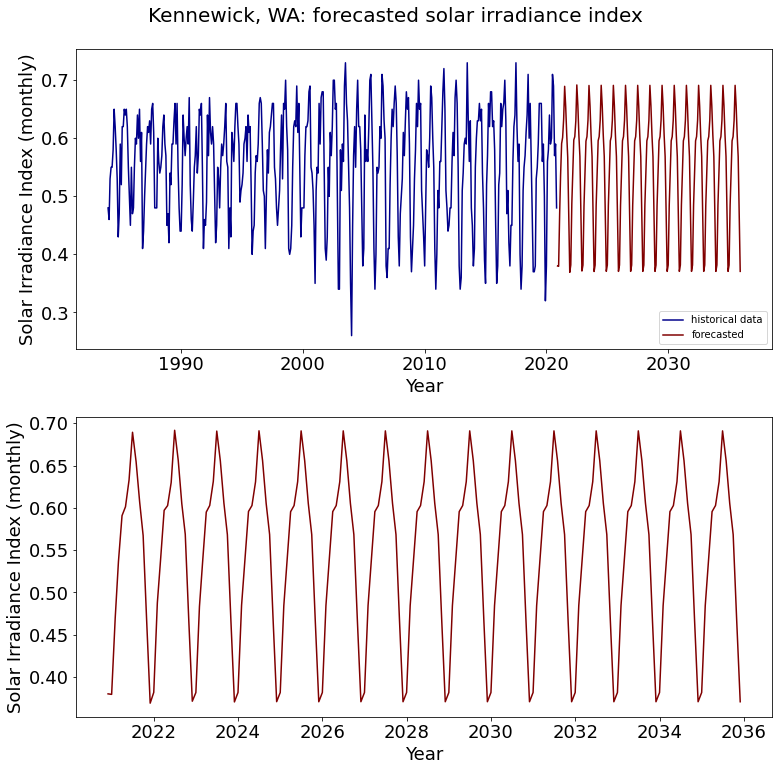

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(11,11))

plt.suptitle('Kennewick, WA: forecasted solar irradiance index', fontsize=20)
ax[0].plot(Kennewick[:443], color='darkblue', label='historical data')
ax[0].plot(Kennewick[443:], color='maroon', label='forecasted')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Solar Irradiance Index (monthly)')
ax[0].legend(loc='lower right', fontsize=10)

ax[1].plot(Kennewick[443:], color='maroon', label='forecasted values')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Solar Irradiance Index (monthly)')


fig.tight_layout()